# Constructing Property Diagrams

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# VDW Equation of State

### Equation of state:
$$P = \dfrac{RT}{\underline{V} - b} - \dfrac{a}{\underline{V}^2}$$ 

where 

$$ a = 27\dfrac{(RT_c)^2}{64P_c} \text{and } b = 0.125\dfrac{RT_c}{P_c}$$ 

### Expression it in its cubic form:

$$ Z^3 + \alpha Z^2 + \beta Z + \gamma = 0 $$

where 

$\quad \alpha = -1 - B$

$\quad \beta = A$

$\quad \gamma = -AB$

where the constants $A$ and $B$ are given as: 

$ A = \dfrac{aP}{RT}^2 $
$ B = \dfrac{bP}{RT}$


### Fugacity expression from Sandler (Eq 7.4-13):

Sandler gives the fugacity coefficient, $\phi$ for the VDW equation of state as:

$$\ln{\phi} = (Z-1) - \ln{(Z-B)} - \dfrac{A}{Z}$$

## Critical Properties of Ethane

In [2]:
MW = 30.070 #g/mol
Tc = 305.4#K
Pc = 4.884*10**6#Pa
Vc = 0.148/1000#(m^3/mol)
w = 0.098
R = 8.314#J/(mol*K)
Zc = Pc*Vc/(R*Tc)
print('%3.3f'%Zc)

0.285


In [3]:
a = 27*(R*Tc)**2/(64*Pc)
b = 0.125*(R*Tc)/Pc

print('%3.2f'%a,'%3.2f'%(b*1000))

0.56 0.06


Text(0.5, 0, '$V (m^3/mol)$')

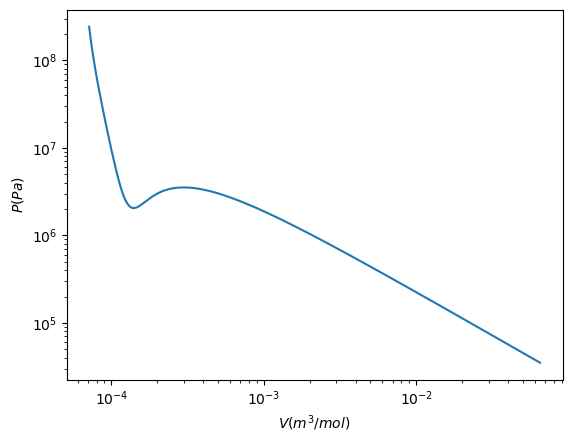

In [4]:
def VDW(V,T):
    '''
    V in m^3/mol
    T in K
    
    returns P in Pa
    '''
    return R*T/(V-b)-a/V**2

V = np.logspace(np.log10(1.1*b), np.log10(1000*b),201)

plt.plot(V,VDW(V, 0.9*Tc))
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$P (Pa)$')
plt.xlabel(r'$V (m^3/mol)$')

### Calculating the Fugacity from the Cubic Form of the E.O.S

In [9]:
def VDW_cubic(T,P):
    '''
    takes in temperature in K
    takes in pressure in Pa
    
    returns roots of the E.oS. in compressibility, Z, and the fugacities of the v and l phases
    '''
    def fugacity(Z):
    
        return  (Z-1) - np.log(Z-B) - A/Z

    A = a*P/(R*T)**2
    B = b*P/(R*T)
    
    roots = np.roots([1, -1 - B, A, -A*B]) ##calculate the compressibility roots
    
    Zv = np.max(roots)
    Zl = np.min(roots)
    
    fv = fugacity(Zv)
    fl = fugacity(Zl)
    
    return roots, [fv,fl]
    
print(VDW_cubic(0.9*Tc,0.8*Pc)) ## 4 imaginary roots meens we are far from Psat
print(VDW_cubic(0.9*Tc,0.7*Pc)) ## 3 real roots, means we are close to Psat

(array([0.45866026+0.16890633j, 0.45866026-0.16890633j,
       0.19379058+0.j        ]), [(-0.3904634865376896+0.01111937814126912j), (-0.46351276114107054+0j)])
(array([0.55667172, 0.36709754, 0.17345296]), [-0.32053620423976903, -0.3544712653571547])


### Finding Psat from the fugacities

1872230.167702808 0.0008135113310225633 0.00010087181932847482


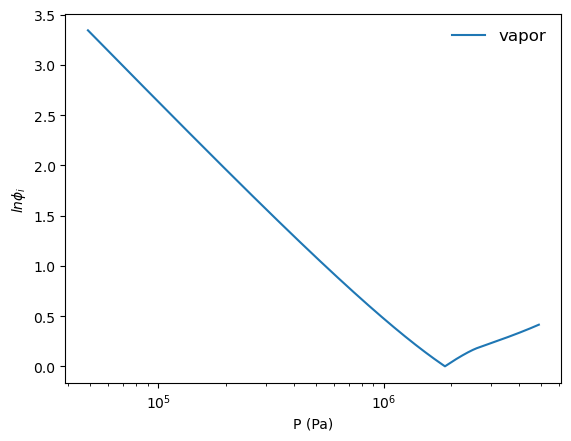

In [6]:
P_  = []
fv_ = []
fl_ = []
Zv_ = []
Zl_ = []

##loop over guess pressures
for Pr in np.logspace(-2,0,1000):
    
    ans = VDW_cubic(0.8*Tc,Pc*Pr)
    
    P_.append(Pr*Pc)
    fv_.append(ans[1][0])
    fl_.append(ans[1][1])
    Zv_.append(np.max(ans[0]))
    Zl_.append(np.min(ans[0]))
P_=np.asarray(P_)
fv_=np.asarray(fv_)
fl_=np.asarray(fl_)

diff = np.abs(fv_-fl_)
i = list(diff).index(np.min(diff))
print(P_[i],Zv_[i]*R*0.8*Tc/P_[i],Zl_[i]*R*0.8*Tc/P_[i])

plt.plot(P_,np.abs(fv_-fl_), label = 'vapor')
#plt.plot(P_,fl_, label = 'liquid')
plt.xscale('log')
plt.xlabel('P (Pa)')
plt.ylabel('$ln\phi_i$')
plt.legend(fontsize=12,frameon=False)